# Simpsons Classifier

Этот ноутбук является итогом работы над соревнованием, суммируя все отработааные подходы и сравнивая их.
Чистки и аугментации данных показывали сперва не самые лучшие результаты. 

Работа включает в себя итоговые 6 сабмитов, для сравнения f-1 score на тестовой выборке.
Подходы:

1. Базовый Simple-net: Baseline вариант, остоящий из пяти блоков вида Batchnorm-Conv2d-ReLU-MaxPool. Данные без предобработки.
2. Базовый Simple-net, однако данные отбалансированы с помощью RandomWeightedSampler.
3. fc2-net: те же пять блоков Batchnorm-Conv2d-ReLU-MaxPool, однако на выходе два полносвязных слоя с Dropout(0.5). Быстрое переобучение стало проблемой, с которой не справилась аугментация данных. За основу взят аналогичный блок из VGG-16 вот **отсюда**.
4. fc2-net с ребалансировкой RandomWeightedSampler и аугментацией данных.
5. TransferLearning.

## Подготовка рабочей среды.

*   Установить билиотеки
*   Подключить GPU
*   разархивировать датасет (и прописать пути)



In [1]:
#!pip install -U torch torchvision

In [2]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
#!pip install Pillow==5.3.0
import PIL
print(PIL.__version__)

9.1.1


In [4]:
from os.path import exists
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
import torch
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    !nvidia-smi

CUDA is available!  Training on GPU ...
Sun Nov 20 06:57:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                

In [5]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [6]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

## Подготовка данных.

*   Расписать класс SimpsonDataset для работы с данными.
*   train-test split
*   Transpose
На практике удобней работать через ImageLoader,  но пока перетачивать этот код под другой метод работы с изображениями не с руки.


In [16]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, transform = None):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
      
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != "test":
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            self.transform = transform

    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
      
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode != 'train':
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = self.transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [7]:
TRAIN_DIR = Path("/kaggle/input/journey-springfield/train/simpsons_dataset")
TEST_DIR = Path("/kaggle/input/journey-springfield/testset/testset")

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [8]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

## Модели

*Описание слоев:*

* размерность входа: 3x224x224
* размерности после слоя: 8x111x111
* 16x54x54
* 32x26x26
* 64x12x12
* выход: 96x5x5

**fit_epoch**  - Обучение модели по эпохам. На вход функции подаются модель, даталоадер, оптимизатор и функция лосса. Функция возвращает лосс и точность после пробега эпохи обучения.

In [10]:
# Обучение модели в рамках одной эпохи. Через даталоадер загружаем батчи, прогоняем forward-backward, возвращаем лосс и аккурэси
def fit_epoch(model, train_loader, optimizer, criterion):
  run_correct = 0 # Количество верных предсказаний, для подсчета лосса
  run_loss = 0 # куммулятивный лосс
  processed_data = 0 # общее число обработанных сэмплов, для подсчета лосса.(Напрямую из лоадера не вытащить?)
  model.train()
  for inputs, labels in train_loader:
    '''
    1. Перекинуть input, label на device.
    2. Обнулить градиент оптимизатора.
    3. Сделать предсказание.
    4. Подсчитать лосс
    5. backward-pass (вызывается в лоссе?)
    6. шаг оптимизатора
    7. Рассчитываем точность и лосс
    '''
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    optimizer.zero_grad()

    output = model(inputs)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    preds = torch.argmax(output, 1)
    run_loss += loss.item() * inputs.size(0)
    #print(f"run_loss: {run_loss}, loss.item: {loss.item()}")
    run_correct += torch.sum(preds == labels.data)
    processed_data += inputs.size(0)

  train_loss = run_loss / processed_data
  train_acc = run_correct.cpu().numpy() / processed_data
  return train_loss, train_acc


На валидационной выборке обучение не идет, в остальном то же самое.

In [11]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size # double()
    return val_loss, val_acc


In [12]:
#
def train(train_files, val_files, model, epochs, batch_size, sampler = None):
  if sampler is None:
    train_loader = DataLoader(train_files, batch_size = batch_size, shuffle = True)
  else:
    train_loader = DataLoader(train_files, batch_size = batch_size, sampler = sampler)
  val_loader = DataLoader(val_files, batch_size = batch_size, shuffle = False)

  history = []
  log_template = "\nEpoch: {ep:03d} train_loss: {t_loss:0.4f} train_accuracy: {t_acc:0.4f}\
  val_loss: {v_loss:0.4f} val_accuracy: {v_acc:0.4f}"

  with tqdm(desc = "epoch", total = epochs) as pbar_outer:
    opt = torch.optim.Adam(model.parameters(), lr=3e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
      train_loss, train_acc = fit_epoch(model, train_loader, opt, criterion)
      print("loss", train_loss)
            
      val_loss, val_acc = eval_epoch(model, val_loader, criterion)
      history.append((train_loss, train_acc, val_loss, val_acc))
          
      pbar_outer.update(1)
      tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                     v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
      
  return history

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [27]:
val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

### Распределение по классам, борьба с дисбалансом

Далее проверяется количество изображений на персонажа в тренировочном сете.
Решение: WeightedRandomSampler. Изображению каждого класса выдается вес, равный $$1/c$$, где *с* - количество изображений данного класса в выборке. Затем (грудо говоря), оно домножается на n-samples - здесь это удвоенная длина тренировочной выборки. 

In [18]:
import pandas as pd
from  torch.utils.data.sampler import WeightedRandomSampler

train_labels = [path.parent.name for path in train_files]
tr_labels_count = pd.Series(train_labels).value_counts()
tr_labels_count

homer_simpson               1684
ned_flanders                1090
moe_szyslak                 1089
lisa_simpson                1015
bart_simpson                1006
marge_simpson                968
krusty_the_clown             904
principal_skinner            895
charles_montgomery_burns     895
milhouse_van_houten          809
chief_wiggum                 739
abraham_grampa_simpson       685
sideshow_bob                 658
apu_nahasapeemapetilon       467
kent_brockman                373
comic_book_guy               352
edna_krabappel               343
nelson_muntz                 269
lenny_leonard                233
mayor_quimby                 185
waylon_smithers              136
maggie_simpson                96
groundskeeper_willie          91
barney_gumble                 80
selma_bouvier                 77
carl_carlson                  74
ralph_wiggum                  67
patty_bouvier                 54
martin_prince                 53
professor_john_frink          49
snake_jail

In [19]:

class_weights = {label: 1./c for label, c in tr_labels_count.items()}
class_weights
sample_weights = [0] * len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_dataset)):
    label_1 = train_dataset.label_encoder.inverse_transform([label])[0]
    class_weight = class_weights.get(label_1)
    sample_weights[i] = class_weight


sampler = WeightedRandomSampler(sample_weights, num_samples = 2*len(train_dataset))


100%|██████████| 15699/15699 [02:28<00:00, 105.72it/s]


#### Legacy-вариант
Работал некорректно, выдавал в целом такое же распределение, как и без сэмплера, лишь увеличивая их количество. Насколько я понимаю, train_weights должен быть списком [] длины train_dataset. Однако почему код ниже не удовлетворяет такому требованию, не до конца ясно. Условие про список не жесткое, ведь и с torch.from_numpy все работало...


In [17]:
'''
import pandas as pd
from  torch.utils.data.sampler import WeightedRandomSampler

train_labels = [path.parent.name for path in train_files]
tr_labels_count = pd.Series(train_labels).value_counts()
weight = 1./tr_labels_count
print(tr_labels_count)
train_weights = np.array([weight[t] for t in train_labels])
train_weights = torch.from_numpy(train_weights)
sampler = WeightedRandomSampler(train_weights, len(train_weights))
'''

'\nimport pandas as pd\nfrom  torch.utils.data.sampler import WeightedRandomSampler\n\ntrain_labels = [path.parent.name for path in train_files]\ntr_labels_count = pd.Series(train_labels).value_counts()\nweight = 1./tr_labels_count\nprint(tr_labels_count)\ntrain_weights = np.array([weight[t] for t in train_labels])\ntrain_weights = torch.from_numpy(train_weights)\nsampler = WeightedRandomSampler(train_weights, len(train_weights))\n'

### Сравнение результатов

Так как сэмплер применяется в даталоадере, придется просуммировать результаты по батчам.

In [18]:
train_loader = DataLoader(train_dataset, batch_size = 100, sampler = sampler)
x = pd.DataFrame()
for _, labels in train_loader:
    lbls = [train_dataset.label_encoder.inverse_transform([label])[0] for label in labels]
    label_count = pd.Series(lbls, index=lbls, name='count').value_counts()
    x = x.append(label_count)
x

,fat_tony,abraham_grampa_simpson,sideshow_bob,waylon_smithers,edna_krabappel,kent_brockman,ralph_wiggum,patty_bouvier,rainier_wolfcastle,selma_bouvier,...,chief_wiggum,marge_simpson,charles_montgomery_burns,professor_john_frink,barney_gumble,bart_simpson,gil,martin_prince,nelson_muntz,principal_skinner
count,6.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
count,2.0,2.0,NaN,2.0,5.0,2.0,4.0,NaN,3.0,3.0,...,3.0,4.0,NaN,3.0,3.0,3.0,1.0,3.0,4.0,3.0
count,2.0,1.0,2.0,1.0,4.0,3.0,1.0,4.0,1.0,3.0,...,4.0,1.0,2.0,2.0,1.0,2.0,3.0,1.0,NaN,2.0
count,NaN,3.0,4.0,2.0,3.0,NaN,1.0,1.0,1.0,4.0,...,NaN,2.0,4.0,2.0,1.0,4.0,3.0,3.0,1.0,4.0
count,3.0,2.0,1.0,NaN,NaN,2.0,3.0,3.0,2.0,1.0,...,4.0,1.0,3.0,3.0,2.0,5.0,2.0,4.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
count,4.0,2.0,3.0,4.0,3.0,2.0,1.0,3.0,2.0,2.0,...,3.0,4.0,1.0,2.0,2.0,4.0,1.0,2.0,3.0,1.0
count,NaN,1.0,1.0,2.0,2.0,1.0,1.0,2.0,5.0,3.0,...,5.0,1.0,1.0,3.0,6.0,1.0,1.0,3.0,2.0,2.0
count,NaN,1.0,2.0,4.0,3.0,5.0,5.0,NaN,2.0,4.0,...,2.0,1.0,NaN,2.0,3.0,8.0,4.0,2.0,5.0,1.0
count,2.0,1.0,1.0,NaN,3.0,4.0,3.0,3.0,2.0,3.0,...,2.0,1.0,4.0,1.0,2.0,2.0,1.0,4.0,1.0,NaN


In [19]:
x = x.fillna(value=0)
y = x.sum(axis = 0)
y


fat_tony                    723.0
abraham_grampa_simpson      742.0
sideshow_bob                750.0
waylon_smithers             729.0
edna_krabappel              730.0
kent_brockman               764.0
ralph_wiggum                734.0
patty_bouvier               730.0
rainier_wolfcastle          777.0
selma_bouvier               722.0
ned_flanders                810.0
sideshow_mel                788.0
troy_mcclure                746.0
otto_mann                   761.0
maggie_simpson              765.0
homer_simpson               781.0
krusty_the_clown            749.0
cletus_spuckler             753.0
mayor_quimby                708.0
lenny_leonard               780.0
comic_book_guy              715.0
milhouse_van_houten         715.0
groundskeeper_willie        774.0
moe_szyslak                 758.0
carl_carlson                758.0
snake_jailbird              719.0
apu_nahasapeemapetilon      765.0
agnes_skinner               770.0
disco_stu                   739.0
lisa_simpson  

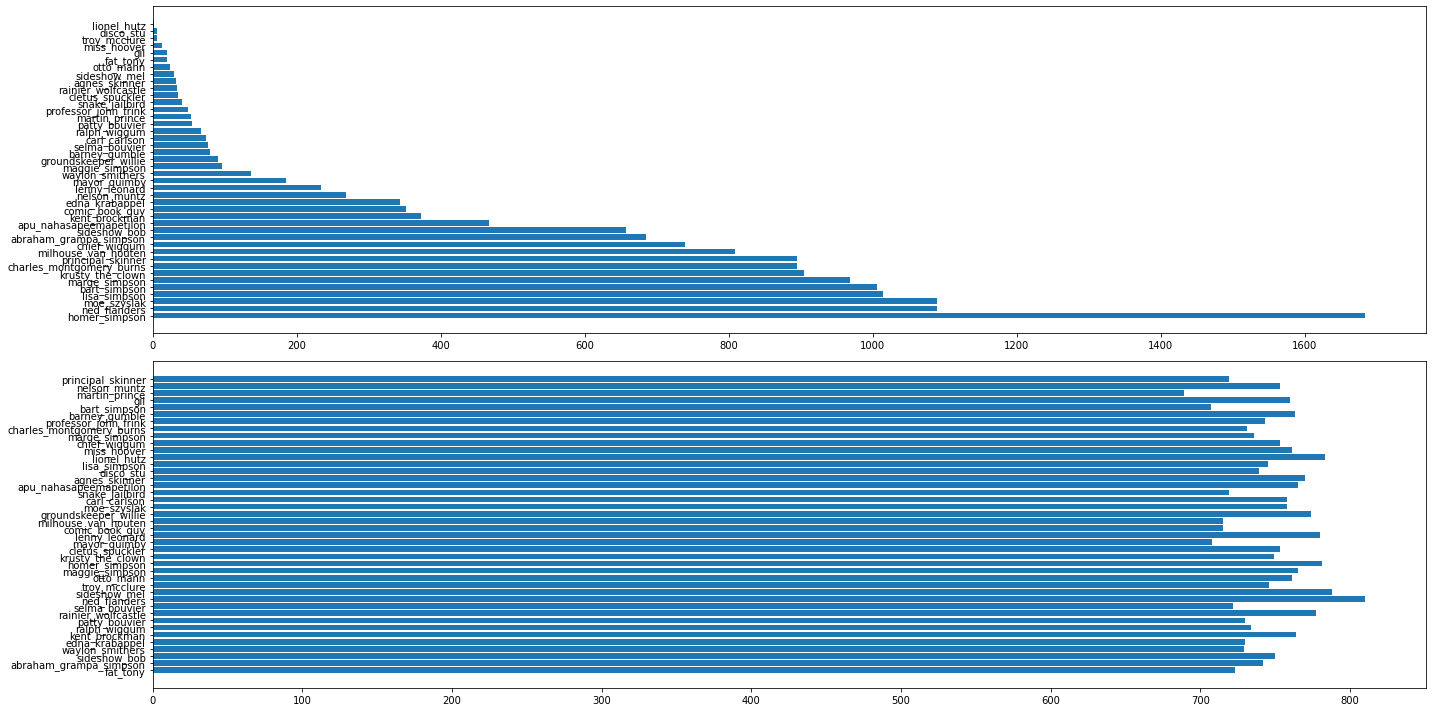

In [20]:
fig, ax = plt.subplots(2, 1, figsize = (20,10))
ax[0].barh(tr_labels_count.index, tr_labels_count)
ax[1].barh(y.index, y)
fig.tight_layout()
plt.show()

Как видно из инфографики, сэмплер исправно работает и справляется с задачей. 

*Наверху - распределение исходного датасета, внизу - пропущенного через даталоадер с WeightedRandomSampler.*

## Сетки.

Рекомендую всем, кто берется за этот "конспект" в рамках курса, разобрать пару рабочих реализаций сетей. 
Для меня большим вдохновением стала вот эта реализация VGG-16: https://github.com/pytorch/vision/blob/main/torchvision/models/vgg.py

Здесь нет смысла уходить свосем в автоматизацию сборки сетки, сверточные слои все же вынесены в отдельный блок.

In [21]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_layer = nn.Sequential(
        nn.BatchNorm2d(in_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    
    def forward(self, x):
        x = self.conv_layer(x)
        return x
    
class SimpleCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = ConvBlock(in_channels = 3, out_channels = 8)
        self.conv2 = ConvBlock(in_channels = 8, out_channels = 16)
        self.conv3 = ConvBlock(in_channels = 16, out_channels = 32)
        self.conv4 = ConvBlock(in_channels = 32, out_channels = 64)
        self.conv5 = ConvBlock(in_channels = 64, out_channels = 96)
        self.out = nn.Linear(96 * 5 * 5, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits


In [20]:
#Отрисовка графиков обучения, accuracy & loss
def visualize_loss_acc(history):
  loss, acc, val_loss, val_acc = zip(*history)
  fig, ax = plt.subplots(1, 2, figsize = (20,10))
  
  ax[0].plot(loss, label="train_loss")
  ax[0].plot(val_loss, label="val_loss")
  ax[0].legend(loc='best')
  ax[0].set_xlabel("epochs")
  ax[0].set_ylabel("loss")

  ax[1].plot(acc, label="train_acc")
  val_accuracy = [i.item() for i in val_acc]
  ax[1].plot(val_accuracy, label="val_acc")
  ax[1].legend(loc='best')
  ax[1].set_xlabel("epochs")
  ax[1].set_ylabel("accuracy")
  plt.show()


In [22]:
torch.manual_seed(42)
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCNN(n_classes).to(DEVICE)
print("we will classify :{} classes".format(n_classes))
simple_cnn

we will classify :42 classes


SimpleCNN(
  (conv1): ConvBlock(
    (conv_layer): Sequential(
      (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv2): ConvBlock(
    (conv_layer): Sequential(
      (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv3): ConvBlock(
    (conv_layer): Sequential(
      (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv4): ConvBlock(
    (conv_layer): 

### **Простая 5-слойная сеть на базовых данных без аугментации и сэмплинга**

In [ ]:


history_01 = train(train_dataset, val_dataset, model=simple_cnn, epochs=4, batch_size=64)

In [23]:
visualize_loss_acc(history_01)

По итогу 25 эпох обучения точность колеблется в районе val_accuracy: 0.85.

### **Простая 5-слойная сеть на базовых данных c сэмплингом**

Следующий тест: базовый вариант сетки, но датасет сбалансирован с помощью WeightRandomSampler.
25 эпох, но в районе 17 точность валидационной выборки уже начинает скакать. Обучение идет медленно. Validation accuracy колеблется около 0.82.

In [ ]:
simple_cnn_03 = SimpleCNN(n_classes).to(DEVICE)

history_02 = train(train_dataset, val_dataset, model=simple_cnn_02, sampler=sampler,
                   epochs=4, batch_size=64)

In [ ]:
visualize_loss_acc(history_02)

резюмирую, особо смысла обучать больше 20 эпох нет.

### ** 5-слойная сеть с двумя двусвязными слоями на выходе, без аугментации и сэмплинга**

Выходные слои - связка Fully Connected, ReLu и Dropout. Так как балансирование классов сделало процесс обучения "более гладким", но не решило проблему переобучения, Dropout - важно.

In [25]:
class SimpleCNN2fc(SimpleCNN):
    def __init__(self, n_classes):
        super().__init__(n_classes)
        
        self.out = nn.Sequential(
            nn.Linear(96 * 5 * 5, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, n_classes),
        )
        
    def forward(self, x):
        return super().forward(x)
        

In [ ]:
fc_net = SimpleCNN2fc(n_classes).to(DEVICE)
fc_net

In [ ]:
history_03 = train(train_dataset, val_dataset, model=fc_net, epochs=10, batch_size=64)

In [ ]:
visualize_loss_acc(history_03)

Сохранить модели

In [ ]:
torch.save(simple_cnn, 'simple_cnn.pth')
torch.save(simple_cnn_02, 'simple_cnn_02.pth')
torch.save(fc_net, 'fc_net.pth')

### ** 5-слойная сеть с двумя двусвязными слоями на выходе, с сэмплингом**
То же самое но на сбалансированных классах.


In [ ]:
fc_net_1 = SimpleCNN2fc(n_classes).to(DEVICE)

history_04 = train(train_dataset, val_dataset, model=fc_net_1, 
                   sampler=sampler, epochs=4, batch_size=64)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 1.8686250221790786


epoch:   5%|▌         | 1/20 [05:03<1:35:58, 303.10s/it]


Epoch: 001 train_loss: 1.8686 train_accuracy: 0.5010  val_loss: 1.6569 val_accuracy: 0.5413
loss 0.743959328290558


epoch:  10%|█         | 2/20 [09:42<1:26:43, 289.11s/it]


Epoch: 002 train_loss: 0.7440 train_accuracy: 0.7943  val_loss: 1.1582 val_accuracy: 0.6685


In [ ]:
visualize_loss_acc(history_04)

### fc_net с аугментацией данных и сэмплингом

In [ ]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=30),
                transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]) 
  
aug_train_dataset = SimpsonsDataset(train_files, mode='train', transform = transform)

In [23]:
fc_net_2 = SimpleCNN2fc(n_classes).to(DEVICE)
history_05 = train(aug_train_dataset, val_dataset,
                   model=fc_net_2, sampler = sampler,
                   epochs=4, batch_size=64)

NameError: name 'AugmentedSimpsonsDataset' is not defined

In [ ]:
visualize_loss_acc(history_05)

### Transfer model. AlexNet

Напоследок опробуем предобученный AlexNet

In [24]:
from torchvision import models
n_classes = len(np.unique(train_val_labels))
transfer_model = models.alexnet(pretrained=True)
transfer_model
transfer_model.classifier = nn.Sequential(
            nn.Linear(9216, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, n_classes),
        )

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [30]:
transfer_model.to(DEVICE)
history_06 = train(train_dataset, val_dataset, model=transfer_model, epochs=4, batch_size=64)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 0.15272366936415332


epoch:   7%|▋         | 1/15 [02:33<35:52, 153.73s/it]


Epoch: 001 train_loss: 0.1527 train_accuracy: 0.9599  val_loss: 0.5569 val_accuracy: 0.8896
loss 0.09840395807825052


epoch:  13%|█▎        | 2/15 [05:09<33:36, 155.09s/it]


Epoch: 002 train_loss: 0.0984 train_accuracy: 0.9718  val_loss: 0.5096 val_accuracy: 0.9117
loss 0.11589863259921682


epoch:  20%|██        | 3/15 [07:45<31:06, 155.55s/it]


Epoch: 003 train_loss: 0.1159 train_accuracy: 0.9711  val_loss: 0.5178 val_accuracy: 0.8913
loss 0.09641391924895414


epoch:  27%|██▋       | 4/15 [10:23<28:41, 156.55s/it]


Epoch: 004 train_loss: 0.0964 train_accuracy: 0.9735  val_loss: 0.4732 val_accuracy: 0.9100
loss 0.08332302323798814


epoch:  33%|███▎      | 5/15 [12:58<25:57, 155.71s/it]


Epoch: 005 train_loss: 0.0833 train_accuracy: 0.9785  val_loss: 0.6145 val_accuracy: 0.8926
loss 0.09129599078965761


epoch:  40%|████      | 6/15 [15:31<23:14, 154.99s/it]


Epoch: 006 train_loss: 0.0913 train_accuracy: 0.9773  val_loss: 0.5901 val_accuracy: 0.9041
loss 0.055252208661300366


epoch:  47%|████▋     | 7/15 [18:05<20:36, 154.60s/it]


Epoch: 007 train_loss: 0.0553 train_accuracy: 0.9868  val_loss: 0.5162 val_accuracy: 0.9113
loss 0.045504603630685335


epoch:  53%|█████▎    | 8/15 [20:38<17:59, 154.21s/it]


Epoch: 008 train_loss: 0.0455 train_accuracy: 0.9894  val_loss: 0.5633 val_accuracy: 0.8976
loss 0.07426171327932043


epoch:  60%|██████    | 9/15 [23:13<15:25, 154.30s/it]


Epoch: 009 train_loss: 0.0743 train_accuracy: 0.9800  val_loss: 0.6429 val_accuracy: 0.8938
loss 0.07780846758709482


epoch:  67%|██████▋   | 10/15 [25:48<12:52, 154.46s/it]


Epoch: 010 train_loss: 0.0778 train_accuracy: 0.9801  val_loss: 0.5679 val_accuracy: 0.9096
loss 0.07661569603975624


epoch:  73%|███████▎  | 11/15 [28:22<10:18, 154.50s/it]


Epoch: 011 train_loss: 0.0766 train_accuracy: 0.9800  val_loss: 0.5893 val_accuracy: 0.9133
loss 0.057412770278892675


epoch:  80%|████████  | 12/15 [30:56<07:42, 154.32s/it]


Epoch: 012 train_loss: 0.0574 train_accuracy: 0.9857  val_loss: 0.5803 val_accuracy: 0.9106
loss 0.04556359144161389


epoch:  87%|████████▋ | 13/15 [33:31<05:08, 154.35s/it]


Epoch: 013 train_loss: 0.0456 train_accuracy: 0.9883  val_loss: 0.6803 val_accuracy: 0.9041
loss 0.05930976344740143


epoch:  93%|█████████▎| 14/15 [36:00<02:32, 152.88s/it]


Epoch: 014 train_loss: 0.0593 train_accuracy: 0.9847  val_loss: 0.5560 val_accuracy: 0.9157
loss 0.08135537516704677


epoch: 100%|██████████| 15/15 [38:28<00:00, 153.89s/it]


Epoch: 015 train_loss: 0.0814 train_accuracy: 0.9804  val_loss: 0.5085 val_accuracy: 0.9083


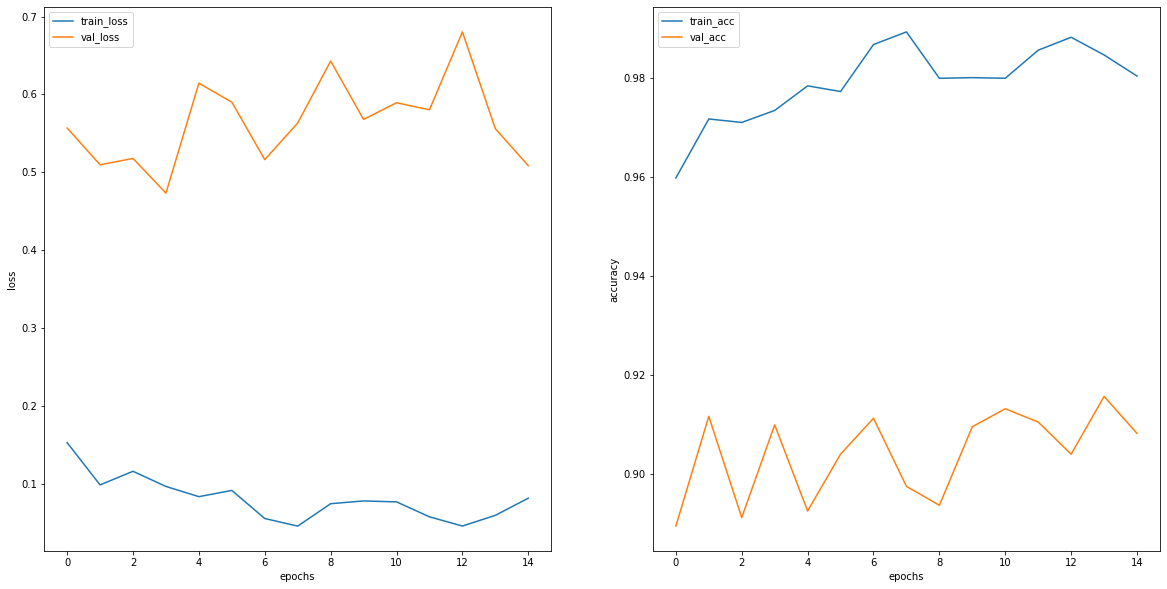

In [32]:
visualize_loss_acc(history_06)

In [34]:


test_dataset = SimpsonsDataset(test_files, mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=30)
test_filenames = [path.name for path in test_dataset.files]
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

#Simple net no class rebalancing
probs_1 = predict(simple_cnn, test_loader)

#for colab:
#my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
preds_1 = label_encoder.inverse_transform(np.argmax(probs_1, axis=1))
submit_1 = pd.DataFrame({'Id': test_filenames, 'Expected': preds_1})
submit_1.to_csv('submission_1_simple.csv', index=False)


#Simple net with class rebalancing
probs_2 = predict(simple_cnn_03, test_loader)
preds_2 = label_encoder.inverse_transform(np.argmax(probs_2, axis=1))
submit_2 = pd.DataFrame({'Id': test_filenames, 'Expected': preds_2})
submit_2.to_csv('submission_2_simple_weights.csv', index=False)


#Simple net with classifier block & no class rebalancing
probs_3 = predict(fc_net, test_loader)
preds_3 = label_encoder.inverse_transform(np.argmax(probs_3, axis=1))
submit_3 = pd.DataFrame({'Id': test_filenames, 'Expected': preds_3})
submit_3.to_csv('submission_3_fc_net.csv', index=False)


#Transfer Alexnet
probs_4 = predict(transfer_model, test_loader)
preds_4 = label_encoder.inverse_transform(np.argmax(probs_4, axis=1))
submit_4 = pd.DataFrame({'Id': test_filenames, 'Expected': preds_4})
submit_4.to_csv('submission_4.csv', index=False)


# Результаты.

* submission-1 - результат fc_net без аугментаций и WeightedSampler.
* submission_4 - результат работы transferred AlexNet. Обучался 15 эпох, осцилировал у одного и того же значения точности.
* Попытки работы с данными, аугментации и сэмплинг лишь ухудшали как качество, так и скорость обучения модели (submission_2_simple_weights). Не все варианты отработаны, как видно, но прогонять полноценный тест на 30 эпох с, в целом, предсказуемым результатом, смыла нет.
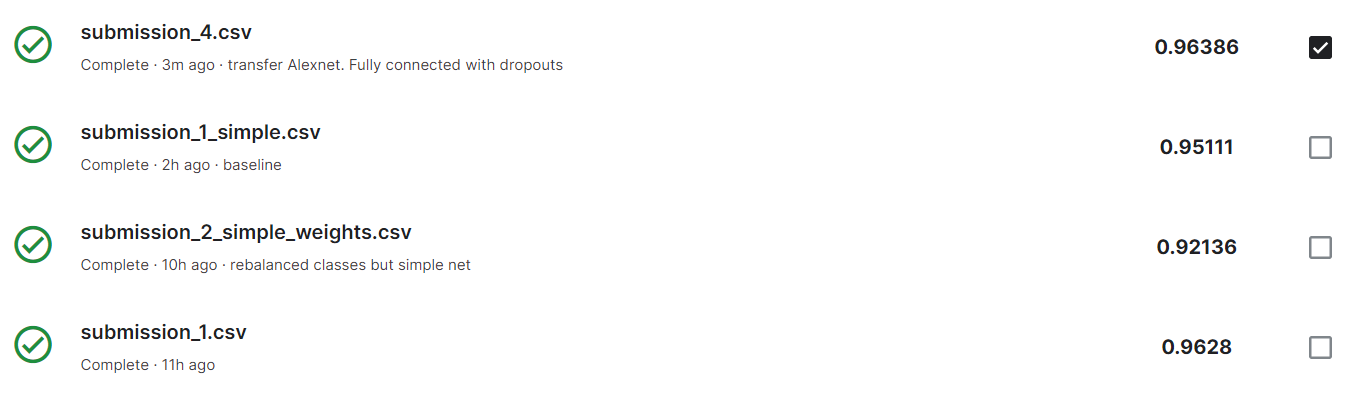